In [281]:
from IPython.display import Image
from PIL import Image as pilImage
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import random
import os

from medvqa.utils.common import WORKSPACE_DIR
from medvqa.utils.files import load_pickle, get_cached_json_file
from medvqa.utils.metrics import chexpert_label_array_to_string, question_label_array_to_string
from medvqa.datasets.mimiccxr import MIMICCXR_CACHE_DIR
from medvqa.utils.logging import print_blue
from medvqa.metrics.classification import MultiLabelPRF1

In [110]:
def load_metadata(results_path):
    exp_name = os.path.basename(os.path.abspath(os.path.join(results_path, os.path.pardir)))
    model_type = os.path.basename(os.path.abspath(os.path.join(results_path, os.path.pardir, os.path.pardir)))
    return get_cached_json_file(os.path.join(WORKSPACE_DIR, 'models', model_type, exp_name, 'metadata.json'))

In [309]:
class ResultsAnalyzer:
    
    def __init__(self, results_path):
        data = load_pickle(results_path)
        self.data = data
        
        n = len(data['image_encoder_gt']['chexpert'])        
        
        self.ie_chexpert_f1_list = []
        self.ie_chexpert_p_list = []
        self.ie_chexpert_r_list = []
        self.ie_chexpert_acc_list = []
        pred_mat = np.empty((n, data['image_encoder_gt']['chexpert'][0].shape[0]))
        gt_mat = np.empty((n, data['image_encoder_gt']['chexpert'][0].shape[0]))
        for i in range(n):
            gt = data['image_encoder_gt']['chexpert'][i]
            pred = data['image_encoder_pred']['chexpert'][i]            
            gt_mat[i] = gt
            pred_mat[i] = pred
            self.ie_chexpert_f1_list.append(f1_score(gt, pred))
            self.ie_chexpert_p_list.append(precision_score(gt, pred))
            self.ie_chexpert_r_list.append(recall_score(gt, pred))
            self.ie_chexpert_acc_list.append(accuracy_score(gt, pred))
        met = MultiLabelPRF1(device='cpu')
        met.update((pred_mat, gt_mat))
        self.ie_chexpert_prf1 = met.compute()
        
        self.gt_mat = gt_mat
        
        self.chexpert_label_2_idxs = [[] for _ in range(14)]
        for i in range(gt_mat.shape[0]):
            for j in range(gt_mat.shape[1]):
                if gt_mat[i][j]:
                    self.chexpert_label_2_idxs[j].append(i)
        
        self.ie_qlabels_f1_list = []
        pred_mat = np.empty((n, data['image_encoder_gt']['qlabels'][0].shape[0]))
        gt_mat = np.empty((n, data['image_encoder_gt']['qlabels'][0].shape[0]))
        for i in range(n):
            gt = data['image_encoder_gt']['qlabels'][i]
            pred = data['image_encoder_pred']['qlabels'][i]            
            gt_mat[i] = gt
            pred_mat[i] = pred
            self.ie_qlabels_f1_list.append(f1_score(gt, pred))
        met = MultiLabelPRF1(device='cpu')
        met.update((pred_mat, gt_mat))
        self.ie_qlabels_prf1 = met.compute()
        
        self.rg_chexpert_f1_list = []
        self.rg_chexpert_p_list = []
        self.rg_chexpert_r_list = []
        self.rg_chexpert_acc_list = []
        pred_mat = np.empty((n, data['report_metrics']['chexpert_labels_gt'][0].shape[0]))
        gt_mat = np.empty((n, data['report_metrics']['chexpert_labels_gt'][0].shape[0]))
        for i in range(n):
            gt = data['report_metrics']['chexpert_labels_gt'][i]
            pred = data['report_metrics']['chexpert_labels_gen'][i]
            gt_mat[i] = gt
            pred_mat[i] = pred
            self.rg_chexpert_f1_list.append(f1_score(gt, pred))
            self.rg_chexpert_p_list.append(precision_score(gt, pred))
            self.rg_chexpert_r_list.append(recall_score(gt, pred))
            self.rg_chexpert_acc_list.append(accuracy_score(gt, pred))
        met = MultiLabelPRF1(device='cpu')
        met.update((pred_mat, gt_mat))
        self.rg_chexpert_prf1 = met.compute()
        
        self.metadata = load_metadata(results_path)
        
        qa_adapted_reports_filename = metadata['mimiccxr_vqa_trainer_kwargs']['qa_adapted_reports_filename']
        self.qa_adapted_reports = get_cached_json_file(os.path.join(MIMICCXR_CACHE_DIR, qa_adapted_reports_filename))
        
    def plot_chexpert_metrics_distribution(self):
        nrows = 4
        ncols = 4

        plt.figure(figsize=(ncols * 6, nrows * 6))

        i = 1

        for met, rg_met_list, ie_met_list in zip(
            ['F1 score', 'Precision', 'Recall', 'Accuracy'],
            [self.rg_chexpert_f1_list, self.rg_chexpert_p_list, self.rg_chexpert_r_list, self.rg_chexpert_acc_list],
            [self.ie_chexpert_f1_list, self.ie_chexpert_p_list, self.ie_chexpert_r_list, self.ie_chexpert_acc_list],
        ):

            ax = plt.subplot(nrows, ncols, i)
            ax.boxplot(rg_met_list)
            ax.set_ylabel(met)
            ax.set_title(f'{met} distribution (report gen)')
            i += 1

            ax = plt.subplot(nrows, ncols, i)
            ax.boxplot(ie_met_list)
            ax.set_ylabel(met)
            ax.set_title(f'{met} distribution (image encoder)')
            i += 1

            ax = plt.subplot(nrows, ncols, i)
            ax.hist(rg_met_list, 50)
            ax.set_xlabel(met)
            ax.set_ylabel('Frequency')
            ax.set_title(f'{met} histogram (report gen)')
            i += 1

            ax = plt.subplot(nrows, ncols, i)
            ax.hist(ie_met_list, 50)
            ax.set_xlabel(met)
            ax.set_ylabel('Frequency')
            ax.set_title(f'{met} histogram (image encoder)')
            i += 1

        plt.show()
        
    def plot_metrics_by_chexpert_label(self):
        
        yticks = [f'{CHEXPERT_LABELS[i]} ({self.gt_mat.T[i].sum():.0f} - {self.gt_mat.T[i].sum()/self.gt_mat.shape[0]*100:.1f}%)' for i in range(14)]

        for k, metric_name in zip(('f1', 'p', 'r'), ('F1 score', 'Precision', 'Recall')):
            plt.figure(figsize=(7, 6))

            micro = self.ie_chexpert_prf1[f'{k}_micro_avg']
            macro = self.ie_chexpert_prf1[f'{k}_macro_avg']
            plt.scatter(self.ie_chexpert_prf1[k], range(14), label=f'image encoder (macro={macro:.3f}, micro={micro:.3f})')

            micro = self.rg_chexpert_prf1[f'{k}_micro_avg']
            macro = self.rg_chexpert_prf1[f'{k}_macro_avg']
            plt.scatter(self.rg_chexpert_prf1[k], range(14), label=f'report genertion (macro={macro:.3f}, micro={micro:.3f})')

            plt.yticks(range(14), yticks)
            plt.xlabel(metric_name)
            plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0),
                  ncol=1, fancybox=True, shadow=True)
            plt.show()
            
    def display_example(self, i):
        data = self.data
        qa_adapted_reports = self.qa_adapted_reports
        
        img = pilImage.open(data['images'][i]).convert('RGB')
        plt.imshow(img)
        plt.show()

        gt_report = data['reports']['gt_reports'][i]

        print_blue('orientation:')
        print('  gt:', data['image_encoder_gt']['orientation'][i])
        print('  pred:', data['image_encoder_pred']['orientation'][i])

        print()
        print_blue('chexpert labels:')
        tmp1 = data['image_encoder_gt']['chexpert'][i]
        print('  gt:\t', tmp1)
        print('     \t', chexpert_label_array_to_string(tmp1))
        tmp2 = data['image_encoder_pred']['chexpert'][i] + 0
        print('  pred:\t', tmp2)
        print('     \t', chexpert_label_array_to_string(tmp2))
        print(f'  f1: {f1_score(tmp1, tmp2):.4f}')

        print()
        print_blue('mined topics labes:')
        tmp1 = data['image_encoder_gt']['qlabels'][i]
        print('   gt:\t', tmp1)
        print('     \t', question_label_array_to_string(qa_adapted_reports['questions'], tmp1))
        tmp2 = data['image_encoder_pred']['qlabels'][i] + 0
        print('   pred:\t', tmp2)
        print('     \t', question_label_array_to_string(qa_adapted_reports['questions'], tmp2))
        print(f'  f1: {f1_score(tmp1, tmp2):.4f}')

        print()
        print_blue('ground truth report:')
        print(gt_report)
        print()
        print(qa_adapted_reports['reports'][gt_report['rid']])
        print()
        with open(qa_adapted_reports['reports'][gt_report['rid']]['filepath'], 'r') as f:
            print(f.read())
        print()
        tmp = qa_adapted_reports['reports'][gt_report['rid']]
        for q, a in tmp['qa'].items():
            q = qa_adapted_reports['questions'][int(q)]
            a = '. '.join(tmp['sentences'][i] for i in a)
            print(colored(q, 'red'), a)

        print()
        print_blue('generated report:')
        gen_report = data['reports']['gen_reports'][i]
        for q, a in zip(gen_report['q'], gen_report['a']):
            print(colored(q, 'red'), a)

        print()
        print_blue('chexpert_labels (report gen):')
        tmp1 = data['report_metrics']['chexpert_labels_gt'][i]
        print('  gt:\t', tmp1)
        print('     \t', chexpert_label_array_to_string(tmp1))
        tmp2 = data['report_metrics']['chexpert_labels_gen'][i]
        print('  gen:\t', tmp2)
        print('     \t', chexpert_label_array_to_string(tmp2))
        print(f'  f1: {f1_score(tmp1, tmp2):.4f}')

        print()
        for k in ['bleu-1', 'bleu-2', 'bleu-3', 'bleu-4', 'ciderD']:        
            print(f'{k}: {data["report_metrics"][k][1][i]:.4f}')
        for k in ['meteor', 'medcomp', 'wmedcomp']:
            print(f'{k}: {data["report_metrics"][k][i]:.4f}')
    
    def display_random_example(self, chexpert_label):
        i = random.choice(self.chexpert_label_2_idxs[chexpert_label])
        self.display_example(i)

# Example 1

In [259]:
results_path = '/home/pamessina/medvqa-workspace/results/vqa/20220926_004746_mim+mim(chex)+iu+iu(chex)+chexp(vqa)+cxr14(vqa)+vinbig(vqa)_oevqa(CenIA-clip-vte-vit-lp16bcbf+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16,0.5,0.4,0.4_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=ground-truth).pkl'

In [260]:
!ls -lh '/home/pamessina/medvqa-workspace/results/vqa/20220926_004746_mim+mim(chex)+iu+iu(chex)+chexp(vqa)+cxr14(vqa)+vinbig(vqa)_oevqa(CenIA-clip-vte-vit-lp16bcbf+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16,0.5,0.4,0.4_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=ground-truth).pkl'

-rw-rw-r-- 1 pamessina pamessina 23M Oct 13 20:08 '/home/pamessina/medvqa-workspace/results/vqa/20220926_004746_mim+mim(chex)+iu+iu(chex)+chexp(vqa)+cxr14(vqa)+vinbig(vqa)_oevqa(CenIA-clip-vte-vit-lp16bcbf+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16,0.5,0.4,0.4_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=ground-truth).pkl'


In [310]:
ra = ResultsAnalyzer(results_path)

/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


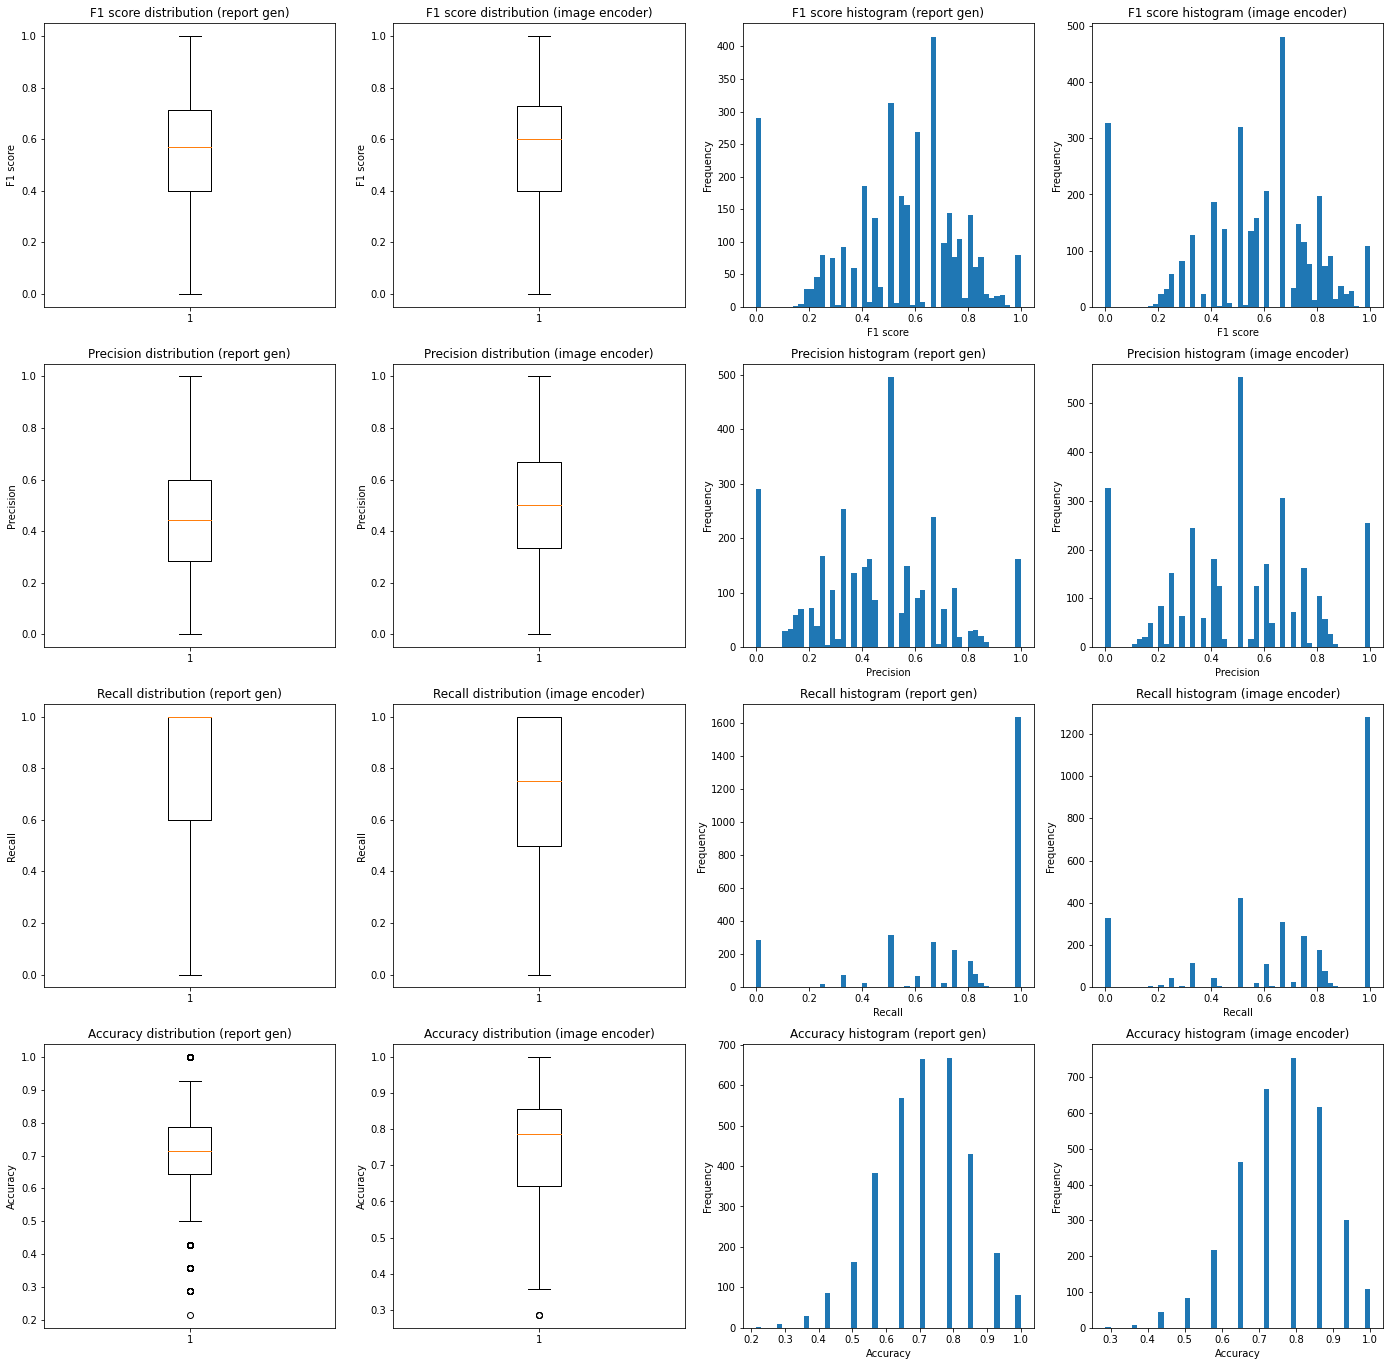

In [311]:
ra.plot_chexpert_metrics_distribution()

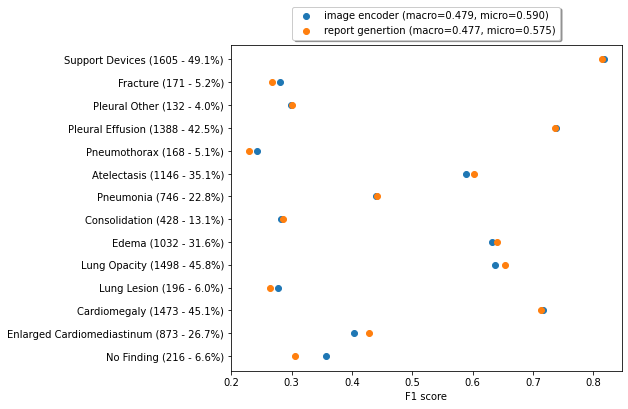

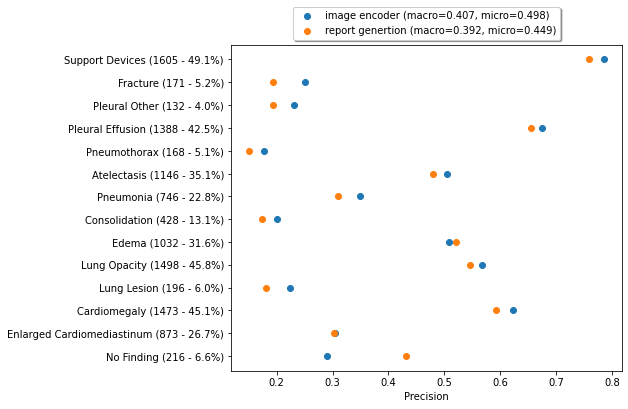

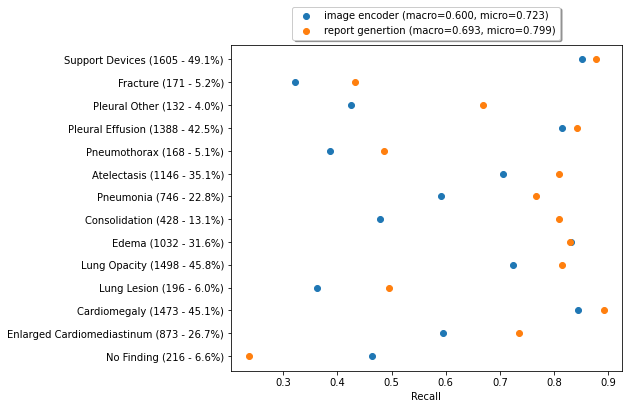

In [312]:
ra.plot_metrics_by_chexpert_label()

In [264]:
ra.metadata

{'tokenizer_kwargs': {'vocab_min_freq': 10,
  'medical_tokenization': True,
  'medical_terms_frequency_filename': 'medical_terms_frequency__20220918_184255.pkl'},
 'model_kwargs': {'embed_size': 256,
  'dropout_prob': 0,
  'pretrained_checkpoint_folder_path': '/home/pamessina/medvqa-workspace/models/vqa/20220925_174700_mim+mim(chex)+iu+iu(chex)+chexp(vqa)+cxr14(vqa)+vinbig(vqa)_oevqa(CenIA-clip-vte-vit-lp16bcbf+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16,0.5,0.4,0.4_medtok_orien_chx_ql_amp/',
  'chexpert_mode': 'vqa',
  'n_questions': 154,
  'visual_input_mode': 'raw-image',
  'raw_image_encoding': 'clip-vit-large-huggingface',
  'freeze_image_encoder': False,
  'image_local_feat_size': 1024,
  'image_encoder_pretrained_weights_path': None,
  'imagenet_pretrained': False,
  'mlp_in_dim': None,
  'mlp_out_dim': None,
  'mlp_hidden_dims': None,
  'clip_version': 'CenIA/vte-vit-large-patch16-bio-clinical-bert-finetuned',
  'question_encoding': 'one-hot',
  'question_vec_size': 128,

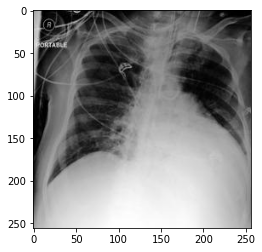

orientation:
  gt: 2
  pred: 2

chexpert labels:
  gt:	 [0 0 0 0 0 0 0 0 0 1 1 0 0 1]
     	 Pneumothorax, Pleural Effusion, Support Devices
  pred:	 [0 1 0 0 1 0 1 0 1 1 1 0 0 1]
     	 Enlarged Cardiomediastinum, Lung Opacity, Consolidation, Atelectasis, Pneumothorax, Pleural Effusion, Support Devices
  f1: 0.6000

mined topics labes:
   gt:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1]
     	 loculation?, lungs?, pleural space?, pneumothorax?, stomach?, support devices and foreign bodies?, tubes and lines?, vena cava?
   pred:	 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1]
     	 apical zone?, atelectasis?, esophagus?, fissures?, fluid?, loculation?, lungs?, opacities?, pleural space

In [267]:
ra.display_random_example(CHEXPERT_LABELS.index('Pneumothorax'))

# Example 2

In [270]:
results_path = '/home/pamessina/medvqa-workspace/results/vqa/20220827_134655_mim+mim(chex)+iu+iu(chex)_oevqa(dense121+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=ground-truth).pkl'

In [269]:
!ls -lh '/home/pamessina/medvqa-workspace/results/vqa/20220827_134655_mim+mim(chex)+iu+iu(chex)_oevqa(dense121+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=ground-truth).pkl'

-rw-rw-r-- 1 pamessina pamessina 22M Oct 16 09:17 '/home/pamessina/medvqa-workspace/results/vqa/20220827_134655_mim+mim(chex)+iu+iu(chex)_oevqa(dense121+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=ground-truth).pkl'


In [313]:
ra2 = ResultsAnalyzer(results_path)

/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


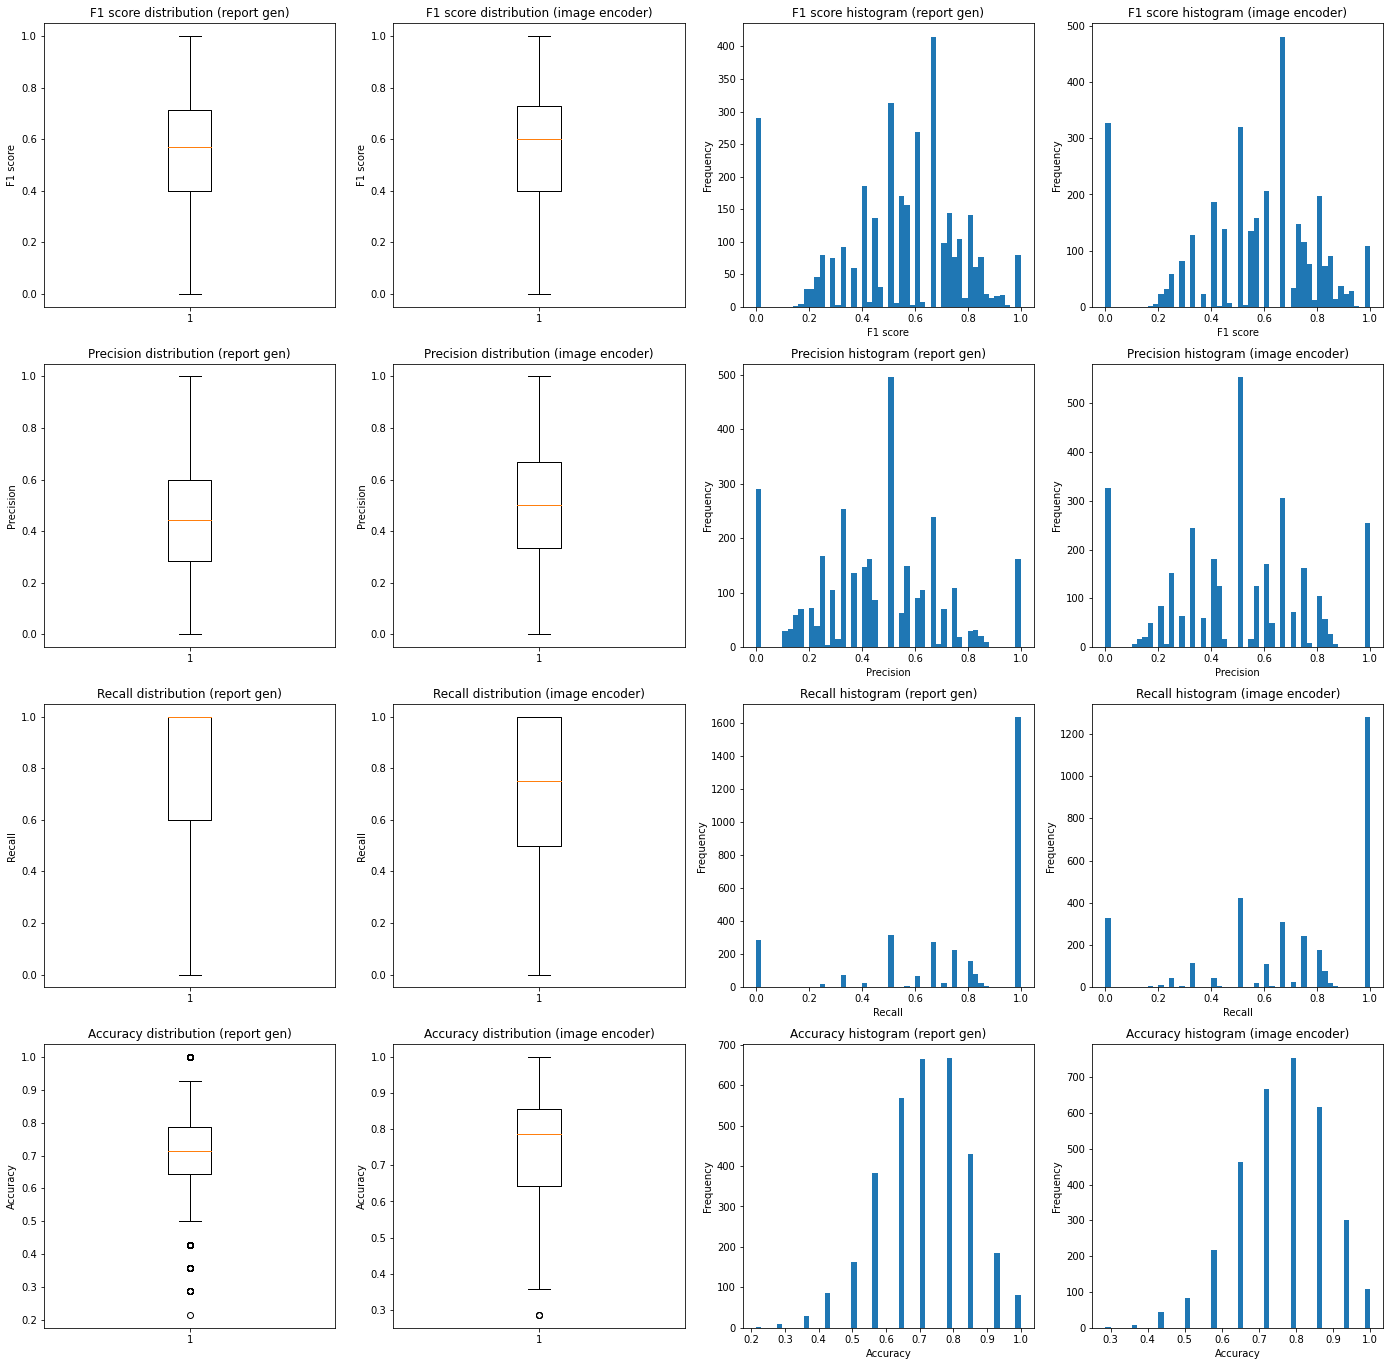

In [314]:
ra2.plot_chexpert_metrics_distribution()

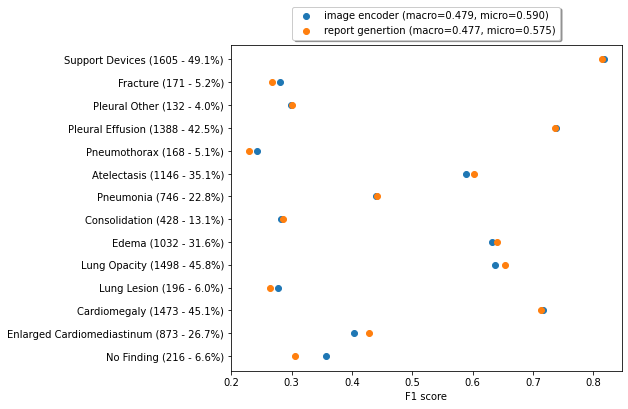

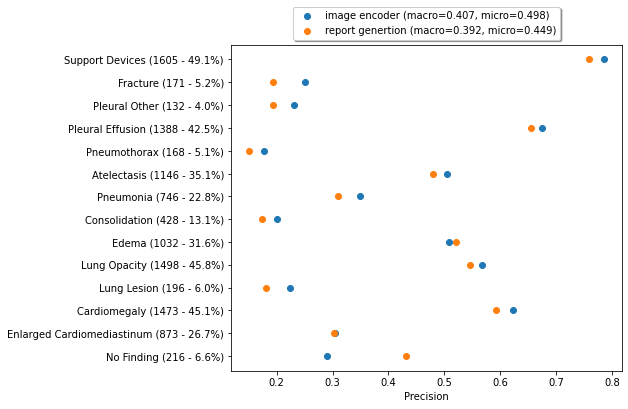

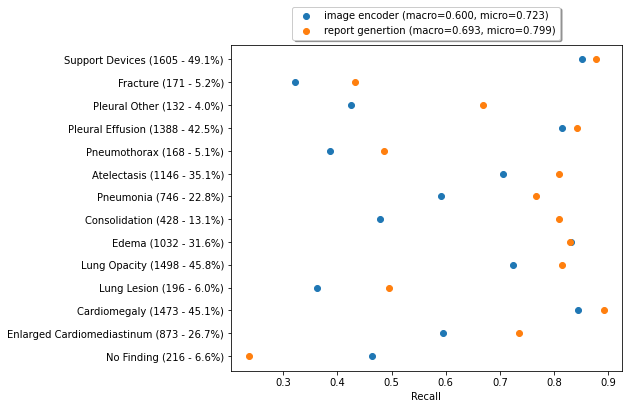

In [315]:
ra2.plot_metrics_by_chexpert_label()

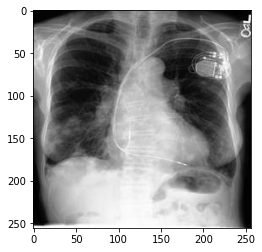

orientation:
  gt: 2
  pred: 2

chexpert labels:
  gt:	 [0 0 1 0 0 1 0 0 0 1 1 0 0 1]
     	 Cardiomegaly, Edema, Pneumothorax, Pleural Effusion, Support Devices
  pred:	 [0 0 1 0 0 1 0 0 0 1 0 0 0 1]
     	 Cardiomegaly, Edema, Pneumothorax, Support Devices
  f1: 0.8889

mined topics labes:
   gt:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0]
     	 cardiac silhouette?, edema?, interstitial lung disease?, lucencies?, lungs?, pleural space?, pneumothorax?, sulci?, support devices and foreign bodies?, tubes and lines?
   pred:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1]
     	 bleeding?, cardiomegaly?, carina?, edema?, esophagus?, fluid overload?, gas distension?, interstitial lung di

In [308]:
ra2.display_random_example(CHEXPERT_LABELS.index('Pneumothorax'))

# Example 3

In [292]:
results_path = '/home/pamessina/medvqa-workspace/results/vqa/20220827_134655_mim+mim(chex)+iu+iu(chex)_oevqa(dense121+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=chexpert-labels).pkl'

In [293]:
!ls -lh '/home/pamessina/medvqa-workspace/results/vqa/20220827_134655_mim+mim(chex)+iu+iu(chex)_oevqa(dense121+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=chexpert-labels).pkl'

-rw-rw-r-- 1 pamessina pamessina 29M Oct 16 10:30 '/home/pamessina/medvqa-workspace/results/vqa/20220827_134655_mim+mim(chex)+iu+iu(chex)_oevqa(dense121+onehot+transf)_visenc-pretr=0_dws=1.0,0.8,0.2,0.16_medtok_orien_chx_ql_amp/mimiccxr_report_results_for_error_analysis(eval_mode=chexpert-labels).pkl'


In [316]:
ra3 = ResultsAnalyzer(results_path)

/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pamessina/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


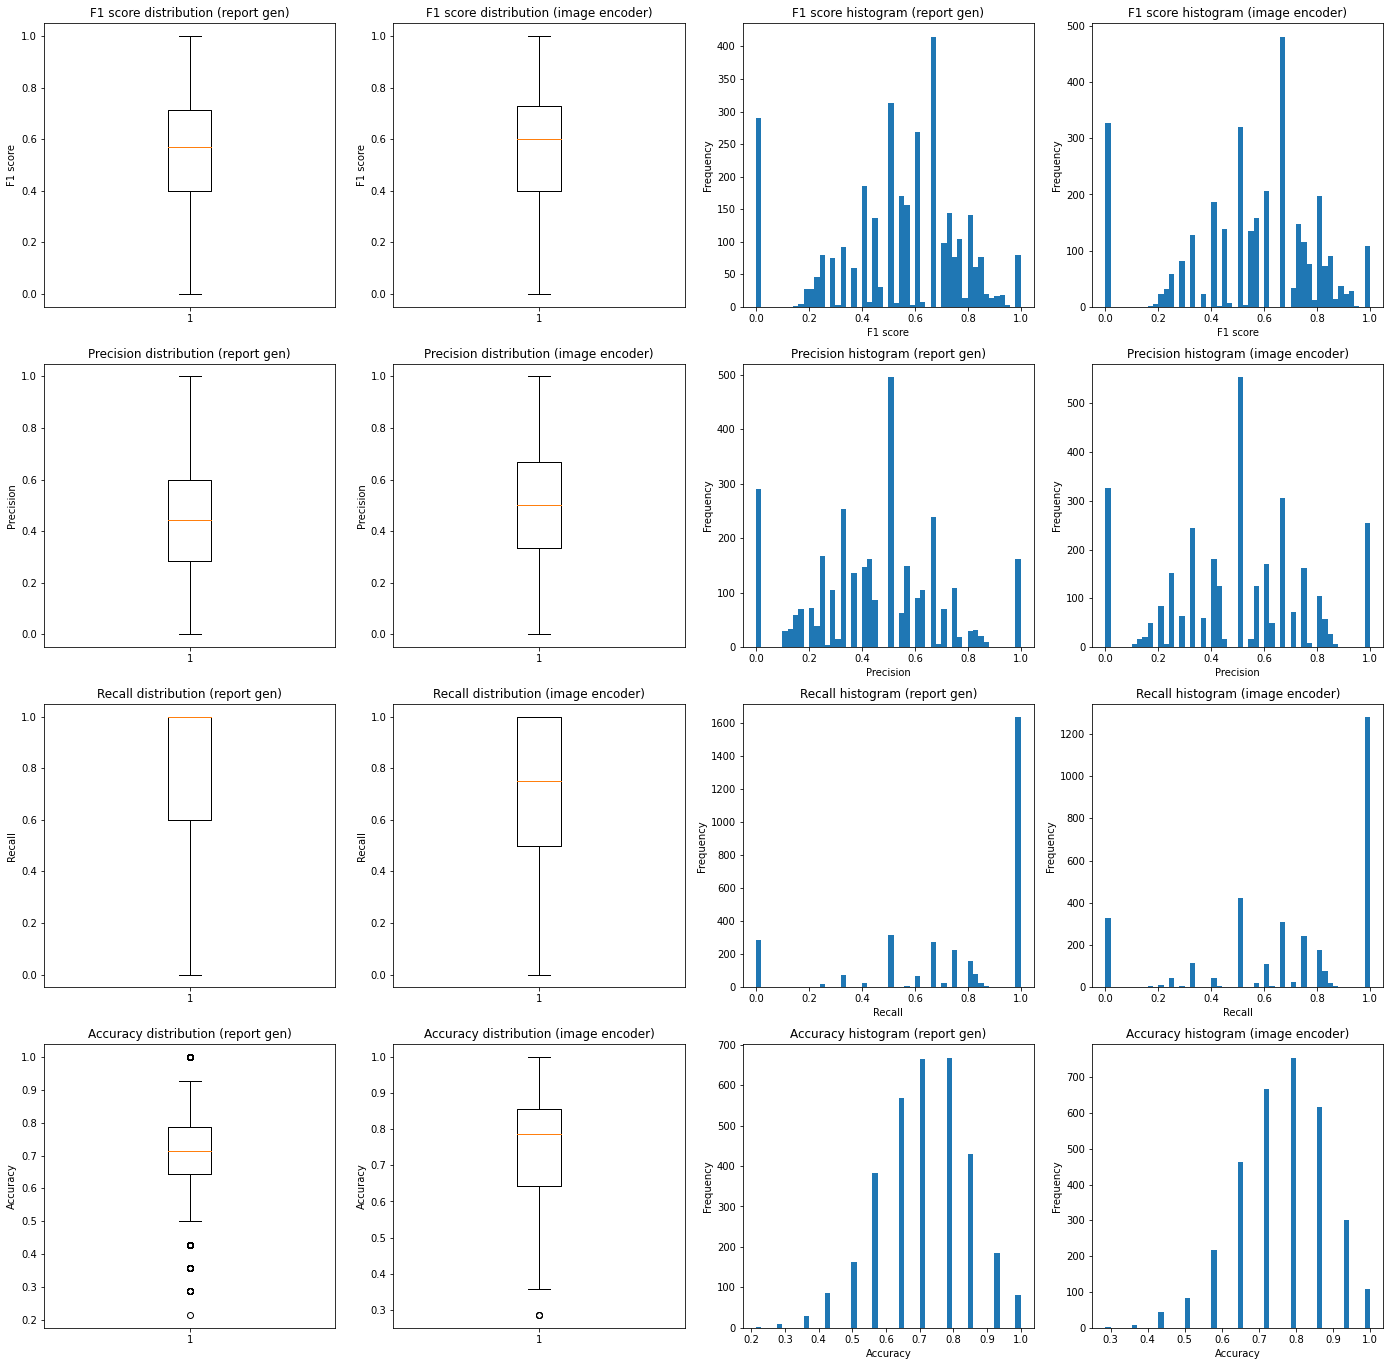

In [317]:
ra3.plot_chexpert_metrics_distribution()

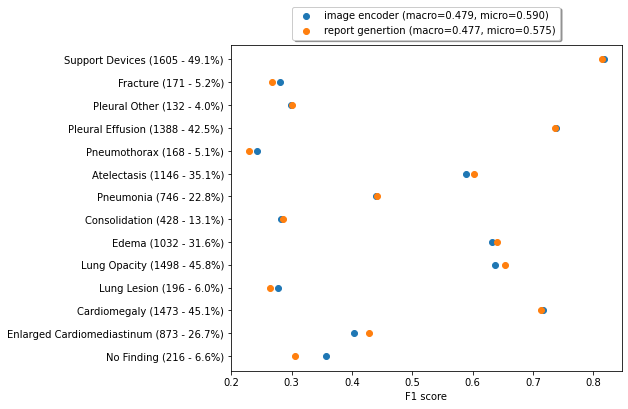

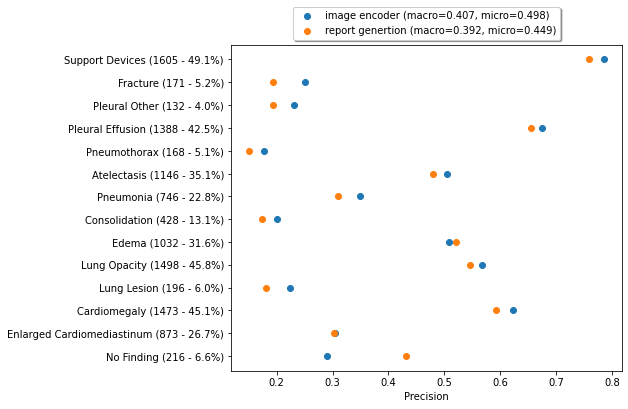

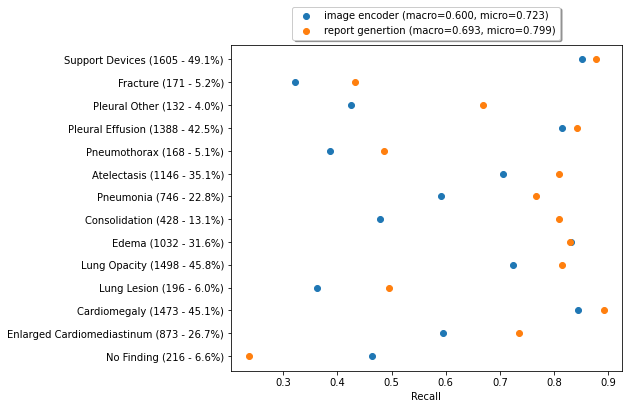

In [318]:
ra3.plot_metrics_by_chexpert_label()

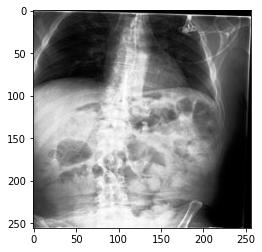

orientation:
  gt: 2
  pred: 2

chexpert labels:
  gt:	 [0 0 0 0 0 0 1 0 0 1 1 0 0 1]
     	 Consolidation, Pneumothorax, Pleural Effusion, Support Devices
  pred:	 [0 0 1 0 0 0 0 0 1 0 0 0 0 1]
     	 Cardiomegaly, Atelectasis, Support Devices
  f1: 0.2857

mined topics labes:
   gt:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0]
     	 consolidation?, esophagus?, fissures?, fluid?, lungs?, pleural space?, pneumothorax?, pulmonary vascularity?, stomach?, support devices and foreign bodies?, tubes and lines?
   pred:	 [0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0]
     	 air collections?, aspiration?, atelectasis?, bowel obstruction and loops?, bowel?, bronchovascular crowding?, bronchus?

In [297]:
ra3.display_random_example(CHEXPERT_LABELS.index('Pneumothorax'))

# Conclusions
- Report generation performance per cheXpert label seems to be greatly influenced by the image enconder's performance
- Improving the image enconder's performance should positively impact report generation performance
- Class imbalances affect the image enconder's performance. We need to more adequately handle class imbalances in training.
- CheXpert labeler sometimes makes mistakes. We need to improve the labeler.